In [1]:
from urllib.parse import urlparse
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import training
import mlflow
import utils

from sklearn.model_selection import train_test_split
from models.model import AttentionResNet
from models.refModel import RefConvNet

print('Tensorflow version: {}'.format(tf.__version__))

2023-01-13 17:48:39.961108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 17:48:41.650129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jens/anaconda3/lib/
2023-01-13 17:48:41.650209: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jens/anaconda3/lib/
2023-01-13 17:48:41.650214: W tensorflow/compiler/tf2tensorrt/utils/py_utils

Tensorflow version: 2.11.0


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-13 17:48:47.065880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-13 17:48:47.319043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-13 17:48:47.319169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
seed = 42
tf.random.set_seed(seed)

# Get data and inspect it

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [14]:
img_height = x_test.shape[1]
img_width = x_test.shape[2]
channels = x_test.shape[3]
print('Training shape: {} \nTesting shape: {}'.format(x_train.shape, x_test.shape))

Training shape: (50000, 32, 32, 3) 
Testing shape: (10000, 32, 32, 3)


In [15]:
y_unique = np.unique(y_train)
label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}
print('Y unique: {}'.format(y_unique))

Y unique: [0 1 2 3 4 5 6 7 8 9]


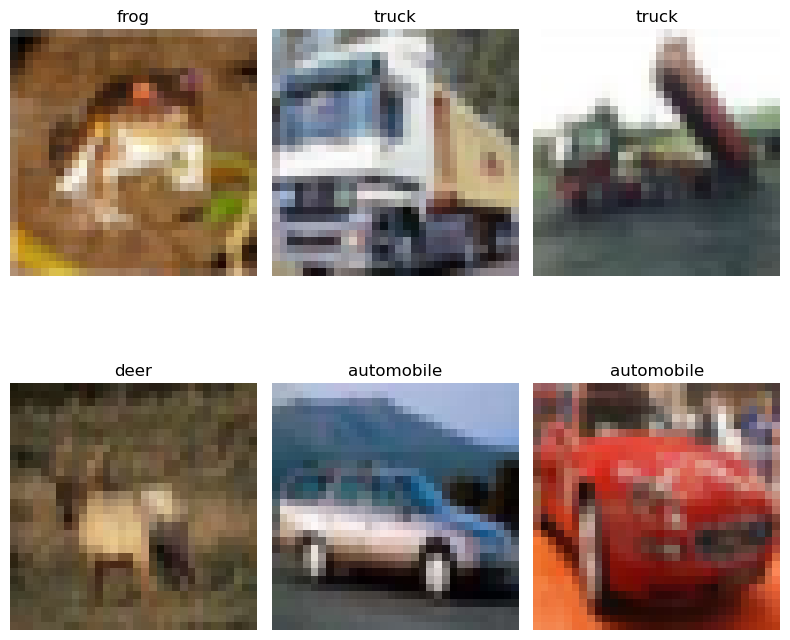

In [16]:
n_draw_images = 6
draw_images = x_train[:n_draw_images]
draw_labels = y_train[:n_draw_images]
draw_labels = [label_map[label[0]] for label in draw_labels]
utils.drawImages(draw_images, draw_labels)

# Prepare data for training

In [17]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [18]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [19]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal_and_vertical'),
    keras.layers.RandomRotation(0.2),
])

# Training

In [20]:
learning_rate = 1e-3

Before we train the res attention net we will train a normal conv model that we will use for benchmarking

In [21]:
conv_model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, channels)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(y_unique))
])

conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

In [22]:
conv_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

2023-01-13 18:07:50.310926: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2023-01-13 18:07:52.511204: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/3
1563/1563 [==============================] - 15s 8ms/step - loss: 1.4723 - accuracy: 0.4616 - val_loss: 1.1630 - val_accuracy: 0.5814
Epoch 2/3
1563/1563 [==============================] - 10s 7ms/step - loss: 1.0923 - accuracy: 0.6130 - val_loss: 1.0320 - val_accuracy: 0.6326
Epoch 3/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9399 - accuracy: 0.6708 - val_loss: 0.9518 - val_accuracy: 0.6630
157/157 - 1s - loss: 0.9594 - accuracy: 0.6696 - 522ms/epoch - 3ms/step


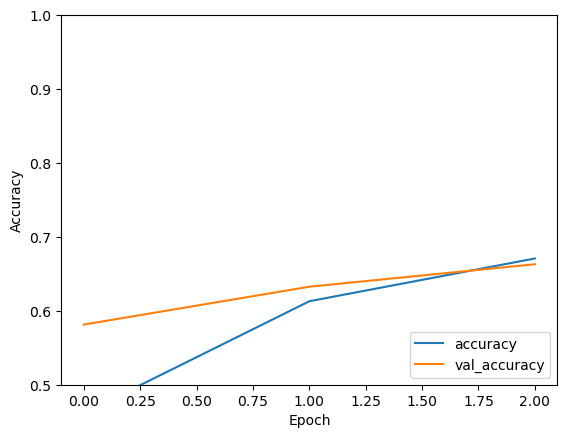

In [23]:
with mlflow.start_run(run_name='test') as run:
    # mlflow.set_tag("mlflow.runName", "Conv example")
    history = conv_model.fit(x_train, y_train, epochs=3, 
                        validation_data=(x_val, y_val))

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = conv_model.evaluate(x_test, y_test, verbose=2)
    print('Test acc {}'.format(test_acc))

    mlflow.log_param('learning rate', learning_rate)
    mlflow.log_metric('train acc', history.history['accuracy'][-1])
    mlflow.log_metric('val acc', history.history['val_accuracy'][-1])
    mlflow.log_metric('test loss', test_loss)
    mlflow.log_metric('test acc', test_acc)

    if urlparse(mlflow.get_tracking_uri()).scheme == 'file':
        mlflow.tensorflow.log_model(conv_model, 'conv_test_model')
    else:
        mlflow.tensorflow.log_model(conv_model, 'conv_test_model', registered_model_name='conv_test_model')
        mlflow.tensorflow.log

# Evaluation